In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

from nyaggle.experiment import run_experiment

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v3_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v3_test_df.parquet')

In [58]:
train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

In [3]:
train_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,...,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no
0,000104bdffaaad1a1e0a9ebacf585f33,96,1,0,1,1,1,0,0,0,...,136135,52732,51851,1379,0,0.016339,0.025044,0.026324,0.025747,0.025022
1,000104bdffaaad1a1e0a9ebacf585f33,902,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1336,0,0.016339,0.025044,0.026324,0.025747,0.039778
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1339,0,0.016339,0.025044,0.026324,0.025747,0.047794
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1349,0,0.016339,0.025044,0.026324,0.025747,0.040073
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0,-1,0,1,-1,-1,0,0,...,136135,52732,51851,1348,0,0.016339,0.025044,0.026324,0.025747,0.040073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14434895,fffe8c99c5b332190c3d4a2d6e7c5073,9368,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,801,4,0.024851,0.030654,0.028250,0.027672,0.012422
14434896,fffe8c99c5b332190c3d4a2d6e7c5073,3046,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,785,4,0.024851,0.030654,0.028250,0.027672,0.007974
14434897,fffe8c99c5b332190c3d4a2d6e7c5073,4732,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,736,4,0.024851,0.030654,0.028250,0.027672,0.018739
14434898,fffe8c99c5b332190c3d4a2d6e7c5073,6214,0,-1,0,1,-1,-1,0,0,...,37724,36204,31431,712,4,0.024851,0.030654,0.028250,0.027672,0.000000


### LightGBM

In [5]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd')]
target = 'target'  # ターゲット変数の列名

# LightGBM のパラメータ
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

In [6]:
# 交差検証の実施
auc_scores = [] # 各foldのAUCスコアを保存するリスト
test_pred = [] # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化


for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # LightGBM モデルの初期化
    model = lgb.LGBMClassifier(**params,
                               n_estimators=10000,
                               n_jobs=-1)

    # モデルの訓練
    model.fit(
        train_data[features], train_data[target],
        eval_set=[(valid_data[features], valid_data[target])],
        early_stopping_rounds=50, verbose=100, eval_metric='binary_logloss'
    )

    # バリデーションデータでの予測と評価
    valid_pred = model.predict_proba(valid_data[features])[:, 1]
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # テストデータでの予測
    test_pred.append(model.predict_proba(test_df[features])[:, 1])
    
    # aucの計算
    auc_score = roc_auc_score(valid_data[target], valid_pred)
    auc_scores.append(auc_score)
    print(f'Fold {fold}: AUC = {auc_score}')

# 平均 AUC の計算
print(f'Mean AUC: {sum(auc_scores) / len(auc_scores)}')


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0682975
[2]	valid_0's binary_logloss: 0.0666535
[3]	valid_0's binary_logloss: 0.0653115
[4]	valid_0's binary_logloss: 0.064173
[5]	valid_0's binary_logloss: 0.0631866
[6]	valid_0's binary_logloss: 0.0623187
[7]	valid_0's binary_logloss: 0.0615462
[8]	valid_0's binary_logloss: 0.0608547
[9]	valid_0's binary_logloss: 0.0602298
[10]	valid_0's binary_logloss: 0.0596632
[11]	valid_0's binary_logloss: 0.059146
[12]	valid_0's binary_logloss: 0.058673
[13]	valid_0's binary_logloss: 0.0582383
[14]	valid_0's binary_logloss: 0.0578392
[15]	valid_0's binary_logloss: 0.0574711
[16]	valid_0's binary_logloss: 0.0571317
[17]	valid_0's binary_logloss: 0.0568174
[18]	valid_0's binary_logloss: 0.0565254
[19]	valid_0's binary_logloss: 0.0562552
[20]	valid_0's binary_logloss: 0.0560044
[21]	valid_0's binary_logloss: 0.0557709
[22]	valid_0's binary_logloss: 0.0555538
[23]	valid_0's binary_logloss: 0.0553516
[24]	valid_0's binary_logloss: 0.0551633
[25]	valid_0's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0683069
[2]	valid_0's binary_logloss: 0.0666771
[3]	valid_0's binary_logloss: 0.0653455
[4]	valid_0's binary_logloss: 0.0642147
[5]	valid_0's binary_logloss: 0.0632357
[6]	valid_0's binary_logloss: 0.0623748
[7]	valid_0's binary_logloss: 0.061608
[8]	valid_0's binary_logloss: 0.0609195
[9]	valid_0's binary_logloss: 0.0602993
[10]	valid_0's binary_logloss: 0.0597368
[11]	valid_0's binary_logloss: 0.0592228
[12]	valid_0's binary_logloss: 0.0587538
[13]	valid_0's binary_logloss: 0.0583229
[14]	valid_0's binary_logloss: 0.0579264
[15]	valid_0's binary_logloss: 0.057561
[16]	valid_0's binary_logloss: 0.0572238
[17]	valid_0's binary_logloss: 0.0569109
[18]	valid_0's binary_logloss: 0.0566209
[19]	valid_0's binary_logloss: 0.0563524
[20]	valid_0's binary_logloss: 0.0561025
[21]	valid_0's binary_logloss: 0.0558699
[22]	valid_0's binary_logloss: 0.0556535
[23]	valid_0's binary_logloss: 0.0554508
[24]	valid_0's binary_logloss: 0.0552626
[25]	valid_0's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0680457
[2]	valid_0's binary_logloss: 0.0664018
[3]	valid_0's binary_logloss: 0.0650622
[4]	valid_0's binary_logloss: 0.063927
[5]	valid_0's binary_logloss: 0.0629439
[6]	valid_0's binary_logloss: 0.0620783
[7]	valid_0's binary_logloss: 0.0613076
[8]	valid_0's binary_logloss: 0.0606179
[9]	valid_0's binary_logloss: 0.0599931
[10]	valid_0's binary_logloss: 0.0594267
[11]	valid_0's binary_logloss: 0.0589112
[12]	valid_0's binary_logloss: 0.0584399
[13]	valid_0's binary_logloss: 0.0580071
[14]	valid_0's binary_logloss: 0.057609
[15]	valid_0's binary_logloss: 0.0572424
[16]	valid_0's binary_logloss: 0.0569031
[17]	valid_0's binary_logloss: 0.0565908
[18]	valid_0's binary_logloss: 0.0563009
[19]	valid_0's binary_logloss: 0.0560314
[20]	valid_0's binary_logloss: 0.055781
[21]	valid_0's binary_logloss: 0.0555486
[22]	valid_0's binary_logloss: 0.0553311
[23]	valid_0's binary_logloss: 0.0551294
[24]	valid_0's binary_logloss: 0.0549407
[25]	valid_0's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.068069
[2]	valid_0's binary_logloss: 0.0664399
[3]	valid_0's binary_logloss: 0.0651105
[4]	valid_0's binary_logloss: 0.063981
[5]	valid_0's binary_logloss: 0.0630039
[6]	valid_0's binary_logloss: 0.0621424
[7]	valid_0's binary_logloss: 0.0613766
[8]	valid_0's binary_logloss: 0.0606903
[9]	valid_0's binary_logloss: 0.06007
[10]	valid_0's binary_logloss: 0.0595077
[11]	valid_0's binary_logloss: 0.0589961
[12]	valid_0's binary_logloss: 0.0585265
[13]	valid_0's binary_logloss: 0.0580966
[14]	valid_0's binary_logloss: 0.0577013
[15]	valid_0's binary_logloss: 0.0573365
[16]	valid_0's binary_logloss: 0.0569992
[17]	valid_0's binary_logloss: 0.0566869
[18]	valid_0's binary_logloss: 0.0563979
[19]	valid_0's binary_logloss: 0.0561294
[20]	valid_0's binary_logloss: 0.0558795
[21]	valid_0's binary_logloss: 0.0556477
[22]	valid_0's binary_logloss: 0.0554309
[23]	valid_0's binary_logloss: 0.0552301
[24]	valid_0's binary_logloss: 0.055042
[25]	valid_0's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.0681635
[2]	valid_0's binary_logloss: 0.066522
[3]	valid_0's binary_logloss: 0.0651832
[4]	valid_0's binary_logloss: 0.0640487
[5]	valid_0's binary_logloss: 0.0630655
[6]	valid_0's binary_logloss: 0.0621991
[7]	valid_0's binary_logloss: 0.061431
[8]	valid_0's binary_logloss: 0.0607424
[9]	valid_0's binary_logloss: 0.0601203
[10]	valid_0's binary_logloss: 0.0595553
[11]	valid_0's binary_logloss: 0.0590403
[12]	valid_0's binary_logloss: 0.0585696
[13]	valid_0's binary_logloss: 0.0581382
[14]	valid_0's binary_logloss: 0.0577414
[15]	valid_0's binary_logloss: 0.0573757
[16]	valid_0's binary_logloss: 0.0570374
[17]	valid_0's binary_logloss: 0.0567256
[18]	valid_0's binary_logloss: 0.0564364
[19]	valid_0's binary_logloss: 0.0561678
[20]	valid_0's binary_logloss: 0.0559186
[21]	valid_0's binary_logloss: 0.0556854
[22]	valid_0's binary_logloss: 0.0554691
[23]	valid_0's binary_logloss: 0.0552671
[24]	valid_0's binary_logloss: 0.0550797
[25]	valid_0's binary_loglo

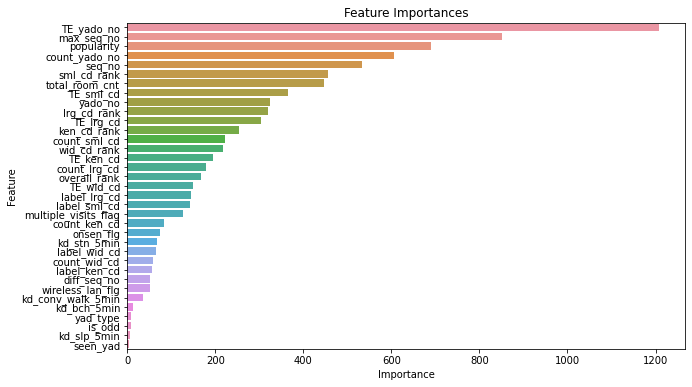

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importances_

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [15]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yado_no', 'oof_pred']].head()

,session_id,yado_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,96,0.768395
1,000104bdffaaad1a1e0a9ebacf585f33,902,0.010438
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0.018227
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0.010513
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0.010513


In [26]:
# Use 'session_id' from train_label to order train_df
train_df_ordered = train_df.set_index('session_id').loc[train_label['session_id']].reset_index()[['session_id', 'yado_no', 'oof_pred']]
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.011386
1,000007603d533d30453cc45d0f3d119f,2808,0.032592
2,000007603d533d30453cc45d0f3d119f,4101,0.009704
3,000007603d533d30453cc45d0f3d119f,5289,0.009397
4,000007603d533d30453cc45d0f3d119f,9187,0.000262


In [43]:
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.011386
1,000007603d533d30453cc45d0f3d119f,2808,0.032592
2,000007603d533d30453cc45d0f3d119f,4101,0.009704
3,000007603d533d30453cc45d0f3d119f,5289,0.009397
4,000007603d533d30453cc45d0f3d119f,9187,0.000262


In [33]:
# train_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = train_df_ordered.sort_values(by=['session_id', 'oof_pred'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
result_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
result_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
result_df = result_df.reset_index()

result_df.head()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,12837,997,7157,5821,12846,4391,11101,11134,1648,1168
1,0000ca043ed437a1472c9d1d154eb49b,2570,8253,8140,13717,825,1092,13682,3184,3564,8677
2,0000d4835cf113316fe447e2f80ba1c8,9039,13642,918,2957,7509,6722,11031,6676,7257,9854
3,0000fcda1ae1b2f431e55a7075d1f500,1341,10483,11715,8355,9790,9438,7812,6178,755,1924
4,000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,12491,10915,1908,11380,5490,1284,902


In [42]:
train_label

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,2259
288694,ffff2360540745117193ecadcdc06538,963
288695,ffff7fb4617164b2604aaf51c40bf82d,13719
288696,ffffcd5bc19d62cad5a3815c87818d83,10619


In [40]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.drop(columns=['session_id']).values

In [37]:
y_true

array([[ 4101],
       [ 8253],
       [ 4863],
       ...,
       [13719],
       [10619],
       [ 2439]])

In [41]:
y_pred

array([[12837,   997,  7157, ..., 11134,  1648,  1168],
       [ 2570,  8253,  8140, ...,  3184,  3564,  8677],
       [ 9039, 13642,   918, ...,  6676,  7257,  9854],
       ...,
       [12240,  4398,  7057, ...,  7308,  3650, 10155],
       [10619, 12500,   570, ..., 11091,  9861,  6933],
       [ 2439,  3848, 10095, ...,  1372,   846,  6579]])

In [46]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 

In [48]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')


Map@10  0.3799286523061886


### 予測ファイルの作成

In [ ]:
#　testデータに結合
#　session_idとyado_noとtargetを結合
#  session_idごとにtargetの上位10件のyado_noを抽出を抽出し、画像のような横10列のデータセットに整形してください

In [53]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[0.89912451 0.0057254  0.00634986 ... 0.0117536  0.0142233  0.00748338]
8735000


In [54]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yado_no', 'target']].head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.899125
1,00001149e9c73985425197104712478c,4545,0.005725
2,00001149e9c73985425197104712478c,9534,0.006350
3,00001149e9c73985425197104712478c,6563,0.005073
4,00001149e9c73985425197104712478c,4420,0.005798


In [59]:
test_session

,session_id
0,00001149e9c73985425197104712478c
1,0000e02747d749a52b7736dfa751e258
2,0000f17ae2628237d78d3a38b009d3be
3,000174a6f7a569b84c5575760d2e9664
4,00017e2a527901c9c41b1acef525d016
...,...
174695,fffee3199ef94b92283239cd5e3534fa
174696,ffff62c6bb49bc9c0fbcf08494a4869c
174697,ffff9a7dcc892875c7a8b821fa436228
174698,ffffb1d30300fe17f661941fd085b04b


In [60]:
# Use 'session_id' from test_session to order test_df
test_df_ordered = test_df.set_index('session_id').loc[test_session['session_id']].reset_index()[['session_id', 'yado_no', 'target']]
test_df_ordered.head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.899125
1,00001149e9c73985425197104712478c,4545,0.005725
2,00001149e9c73985425197104712478c,9534,0.006350
3,00001149e9c73985425197104712478c,6563,0.005073
4,00001149e9c73985425197104712478c,4420,0.005798


In [69]:
test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.899125
21,00001149e9c73985425197104712478c,9830,0.034777
27,00001149e9c73985425197104712478c,6766,0.024048
10,00001149e9c73985425197104712478c,2680,0.019881
24,00001149e9c73985425197104712478c,11496,0.016131
...,...,...,...
8734990,ffffe984aafd6127ce8e43e3ca40c79d,5508,0.001616
8734966,ffffe984aafd6127ce8e43e3ca40c79d,9168,0.000403
8734968,ffffe984aafd6127ce8e43e3ca40c79d,9182,0.000274
8734967,ffffe984aafd6127ce8e43e3ca40c79d,9190,0.000274


In [70]:
# test_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
submit_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
submit_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
submit_df = submit_df.reset_index()

submit_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,9830,6766,2680,11496,2040,5466,11561,4948,10965
1,0000e02747d749a52b7736dfa751e258,12862,6555,4066,143,11237,1266,7014,5267,5055,11923
2,0000f17ae2628237d78d3a38b009d3be,757,9910,410,2267,11001,6730,6721,10485,7710,10104
3,000174a6f7a569b84c5575760d2e9664,12341,277,6991,2795,5657,3359,2047,7413,10861,9319
4,00017e2a527901c9c41b1acef525d016,12029,5713,3844,6576,9623,12524,5372,13590,5106,3187


In [72]:
# 欠損がないかをチェック
print(submit_df.isnull().sum(axis=1).sum())
print(submit_df.shape)

0
(174700, 11)


In [73]:
submit_df.drop(columns=['session_id']).to_csv('../submissions/lgbBinary_ver1.csv', index=False)